# Instrumentation amplifier

Problem: Choose resistors to minimize the uncertainty of the amplifier gain.

(Ref: Figure 5-12 in Thackray, Electronic Design)

![Amplifier](inst_amp.png)

The textbook equation for gain is $-\frac{R_4}{R_3}(1+\frac{2 R_2}{R_1})$. However, the resistor pairs (e.g. both $R_2$'s) will not be identical, but pulled from the same distribution. We need to re-derive the gain expression keeping the resistor pairs separate. Instead of doing a bunch of ugly algebra, we can set up the current equations and use Sympy to solve the system.

In [1]:
import sympy
import numpy as np
import matplotlib.pyplot as plt

import suncal

In [2]:
vs1, vs2, vo1, vo2 = sympy.symbols(['v_s1', 'v_s2', 'v_o1','v_o2'])
R22, R21, R3a, R3b, R4a, R4b = sympy.symbols(['R_21', 'R_22', 'R_3a','R_3b','R_4a','R_4b'])
a3, vo, R1, R2, R3, R4 = sympy.symbols(['a3', 'vo', 'R_1', 'R_2','R_3', 'R_4'])
eqn1 = sympy.Eq((vo1-a3)/R3a, (a3-vo)/R4a)
eqn2 = sympy.Eq((vo2-a3)/R3b,  a3/R4b)
eqn3 = sympy.Eq((vo1-vs1)/R21, (vs1-vs2)/R1)
eqn4 = sympy.Eq((vo2-vs2)/R22, (vs2-vs1)/R1)
vout = sympy.solve((eqn1, eqn2, eqn3, eqn4), (a3,vo1,vo2,vo))
vout = vout[vo].simplify()
vout

(R_1*R_3a*R_4b*v_s2 - R_1*R_3b*R_4a*v_s1 - R_1*R_4a*R_4b*v_s1 + R_1*R_4a*R_4b*v_s2 - R_21*R_3a*R_4b*v_s1 + R_21*R_3a*R_4b*v_s2 - R_21*R_4a*R_4b*v_s1 + R_21*R_4a*R_4b*v_s2 - R_22*R_3b*R_4a*v_s1 + R_22*R_3b*R_4a*v_s2 - R_22*R_4a*R_4b*v_s1 + R_22*R_4a*R_4b*v_s2)/(R_1*R_3a*(R_3b + R_4b))

Double check: if the resistor pairs are equal (R_1a == R1b, etc), the expression should reduce to $-\frac{R_4}{R_3}(1+\frac{2 R_2}{R_1})(v_{s1}-v_{s2})$.

In [3]:
vout_simp = vout.subs({'R_3a':R3,'R_3b':R3,'R_4a':R4,'R_4b':R4, 'R_22':R2, 'R_21':R2}).factor()
vout_simp

-R_4*(R_1 + 2*R_2)*(v_s1 - v_s2)/(R_1*R_3)

Now that we have our expression, send it in to the calculator. Make up some resistor values, and start with all 5% tolerance. This is assuming that 5% is normally distributed, which may or may not be valid.

Report the sensitivity coefficients to see which resistor has the most influence.

In [4]:
model = suncal.Model(vout, 'gain=f1/(v_s1-v_s2)')
model.var('R_1').measure(10000).typeb(unc='5%')
model.var('R_21').measure(47000).typeb(unc='5%')
model.var('R_22').measure(47000).typeb(unc='5%')
model.var('R_3a').measure(22000).typeb(unc='5%')
model.var('R_3b').measure(22000).typeb(unc='5%')
model.var('R_4a').measure(22000).typeb(unc='5%')
model.var('R_4b').measure(22000).typeb(unc='5%')
model.var('v_s1').measure(0.010).typeb(unc='1E-6')
model.var('v_s2').measure(-0.010).typeb(unc='1E-6')
result = model.calculate_gum()
result.report.sensitivity()

## $f_{1}$


|Variable   | Sensitivity   | Proportion  |
|----------|-------------|------------|
|$R_{1}$   | 0.000019      | 33.00%      |
|$R_{21}$   | -2.0e-06      | 8.25%       |
|$R_{22}$   | -2.0e-06      | 8.25%       |
|$R_{3a}$   | 7.1e-06      | 22.72%      |
|$R_{3b}$   | 2.4e-06      | 2.52%       |
|$R_{4a}$   | -7.1e-06      | 22.72%      |
|$R_{4b}$   | -2.4e-06      | 2.52%       |
|$v_{s1}$   | -10.4      | 0.00%       |
|$v_{s2}$   | 10.4      | 0.00%       |


## $gain$


|Variable   | Sensitivity   | Proportion  |
|----------|-------------|------------|
|$R_{1}$  | 0.00094      | 33.00%      |
|$R_{21}$  | -0.00010     | 8.25%       |
|$R_{22}$  | -0.00010     | 8.25%       |
|$R_{3a}$  | 0.00035     | 22.72%      |
|$R_{3b}$  | 0.00012     | 2.52%       |
|$R_{4a}$  | -0.00035     | 22.72%      |
|$R_{4b}$  | -0.00012     | 2.52%       |
|$v_{s1}$  | 0.0     | 0.00%       |
|$v_{s2}$  | 0.0     | 0.00%       |

R1 is most of uncertainty. Change it to 1% and see how it looks.

In [5]:
model.var('R_1').clear_typeb().typeb(unc='1%')
result = model.calculate_gum()
result.report.sensitivity()

## $f_{1}$


|Variable   | Sensitivity   | Proportion  |
|----------|-------------|------------|
|$R_{1}$   | 0.000019      | 1.93%       |
|$R_{21}$   | -2.0e-06      | 12.08%      |
|$R_{22}$   | -2.0e-06      | 12.08%      |
|$R_{3a}$   | 7.1e-06      | 33.26%      |
|$R_{3b}$   | 2.4e-06      | 3.70%       |
|$R_{4a}$   | -7.1e-06      | 33.26%      |
|$R_{4b}$   | -2.4e-06      | 3.70%       |
|$v_{s1}$   | -10.4      | 0.00%       |
|$v_{s2}$   | 10.4      | 0.00%       |


## $gain$


|Variable   | Sensitivity   | Proportion  |
|----------|-------------|------------|
|$R_{1}$  | 0.00094      | 1.93%       |
|$R_{21}$  | -0.00010     | 12.08%      |
|$R_{22}$  | -0.00010     | 12.08%      |
|$R_{3a}$  | 0.00035     | 33.26%      |
|$R_{3b}$  | 0.00012     | 3.70%       |
|$R_{4a}$  | -0.00035     | 33.26%      |
|$R_{4b}$  | -0.00012     | 3.70%       |
|$v_{s1}$  | 0.0     | 0.00%       |
|$v_{s2}$  | 0.0     | 0.00%       |

### Optimize stages

The amplifier has two stages. For constant gain $A = A_1 \times A_2$. Does it matter where we set each stage to for uncertainty purposes?

Here we'll loop the solution, changing resistor values over a range of possible gain combinations.

In [6]:
Atot = 100
A1list = np.linspace(1,Atot*.99,num=50)
percent_uncert = np.zeros_like(A1list)
for i, A1 in enumerate(A1list):
    R1 = 10000
    R3 = 22000
    A2 = Atot/A1
    R4 = A1 * R3
    R2 = (A2 - 1) * R1 / 2

    model = suncal.Model(vout)
    model.var('R_1').measure(R1).typeb(unc='5%')
    model.var('R_21').measure(R2).typeb(unc='5%')
    model.var('R_22').measure(R2).typeb(unc='5%')
    model.var('R_3a').measure(R3).typeb(unc='5%')
    model.var('R_3b').measure(R3).typeb(unc='5%')
    model.var('R_4a').measure(R4).typeb(unc='5%')
    model.var('R_4b').measure(R4).typeb(unc='5%')
    model.var('v_s1').measure(0.010).typeb(unc='1E-6')
    model.var('v_s2').measure(-0.010).typeb(unc='1E-6')
    result = model.calculate_gum()
    percent_uncert[i] = abs(result.uncertainty['f1'] / result.expected['f1'])

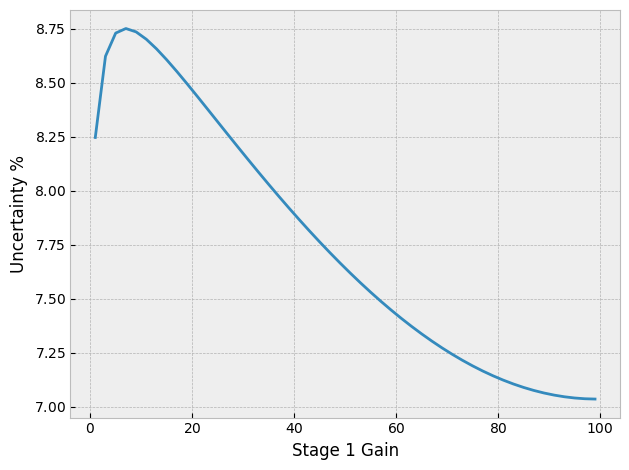

In [7]:
plt.plot(A1list, percent_uncert*100, lw=2)
plt.xlabel('Stage 1 Gain')
plt.ylabel('Uncertainty %')
plt.tight_layout()